# Requirements

In [85]:
!pip install pandas 
!pip install memory-profiler psutil

In [ ]:
%pip install datasketch rapidfuzz pandas numpy matplotlib

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 3.4 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 2.1 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 2.1 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.4 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


# Libraries

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import textdistance
import snowflake.connector
from snowflake.snowpark import Session

import os
import logging
from typing import Iterable, Dict, Tuple, Set, Sequence, List
from datasketch import MinHash, MinHashLSH
from rapidfuzz.distance import DamerauLevenshtein as DL

from rapidfuzz.distance import JaroWinkler as JW
from rapidfuzz import fuzz

# Profiling

In [86]:
import time
import psutil
import os
from memory_profiler import memory_usage
from functools import wraps
 
def profile(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        process = psutil.Process(os.getpid())
        start_time = time.time()
        start_cpu = process.cpu_times()
 
        mem_usage, result = memory_usage(
            (func, args, kwargs),
            retval=True,
            interval=0.1,
            timeout=None
        )
 
        end_time = time.time()
        end_cpu = process.cpu_times()
 
        print(f"Wall time: {end_time - start_time:.4f} seconds")
        print(f"User CPU time: {end_cpu.user - start_cpu.user:.4f} seconds")
        print(f"System CPU time: {end_cpu.system - start_cpu.system:.4f} seconds")
        print(f"Peak memory usage: {max(mem_usage):.2f} MiB")
 
        return result
 
    return wrapper

# Auth

In [6]:
connection_parameters = {"account": "a40937.eu-central-1", "user": "jpra@uefa.ch", "role":"ML_SPECIALIST_ROLE", "database":"UEFA_DEV_DWH", "schema":"ML_SANDBOX", "warehouse": "DA_ML_VWH", "authenticator":"externalbrowser"}
session = Session.builder.configs(connection_parameters).create()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/86c909a2-695c-4f9c-84fe-0371d2e68653/saml2?SAMLRequest=pZNRb9owFIX%2FSuQ9J3FCCMQiVBmIDo12rKSbtDcvuQELx85sh7T8%2BjkBpO6hfdmbZZ%2Fr79x77NndS82dEyjNpEhR4GHkgChkycQ%2BRc%2F5yp0iRxsqSsqlgBS9gkZ385mmNW9I1pqDeII%2FLWjj2IuEJv1BiloliKSaaSJoDZqYguyyhw0JPUyo1qCMxaFrSamZZR2MaYjvd13ndSNPqr0fYox9nPhW1Us%2BoTeI5mNGo6SRheS3khfb0zuIwMdRj7AKS9heCz8zcRnBR5TfF5EmX%2FJ8626%2F7XLkZLfuFlLotga1A3ViBTw%2FbS4GtHWQRTgZTTxo3QKEUZS7gdcodqIGOBNHTwvZVZweoZB10xrL8OzKr6D0udwzO7n1MkXNkZX3%2B%2Fs8OIjdObuP1z9Hu3NzzppjvDqs4vHm6%2FdskzUiaBfQdg8Fcn7ccg77nNdat7AWfbrGbuFw7AbYxdMcT0gUkXDiBZPwF3KWNl0mqBkqby0MPryaFUpqWRkprHEYXE7jIsEJDd04GRduVCWFO40qcPFoEpQhxNN4PPL7DEN0eUdkMKLm%2Fzedmf%2F2rusDfbSZrZdbyVnx6qykqql5P9LAC4YdVrrVICVQU8azslSgtY2Wc9ktFFgfKTKq

# Snowflake Connection

In [7]:
conn = snowflake.connector.connect(
    user="jpra@uefa.ch", # 
    authenticator="externalbrowser", 
    account="a40937.eu-central-1", 
    warehouse = 'UEFA_DEV_BI_TEAM_VWH',
    database = 'UEFA_DEV_DWH',
    schema = 'ML_SANDBOX'
)

# Data Loading

In [106]:
cur = conn.cursor()

try: 
    query = """
            select * 
            from DS_LOTTERY_AI_DATA_CLEANSING_UECLF24 
            tablesample (1000 rows)
            """

    cur.execute(query)
    data = cur.fetchall()

finally:

    cur.close()
    
df = pd.DataFrame(data=data, columns=[col[0] for col in cur.description])

# Data Preparation

In [107]:
def rename_vars(df: pd.DataFrame) -> pd.DataFrame:

       renames = {'CLEANSED OUT (COMBINATION ALL CHECKS)': 'cleansed', 'ID_NUMBER': 'passport_id',
              'Contact Number': 'contact_number', 'First name': 'first_name', 'Last name': 'last_name', 'Full name': 'full_name', 'Birthday': 'birthday',
              'Email': 'email', 'Mobile': 'mobile', 'City': 'city', 'Country': 'country', 'Postcode': 'postcode',
              'I am a fan of - UECLF 2024 (extended export)': 'ueclf_24_fan_of', 
              "'Increase your chances - UELF 2024'": 'uelf_24_app_increase_chances',
              "'I want to take part in the draw - UELF 2024'": 'uelf_24_app', 'Tenant ID': 'competition_id',
              'Application for UECLF?': 'ueclf_24_app', 'Application for UELF?': 'uelf_25_app',
              'Application for UCLF?': 'uclf_24_app', 'Risk Score': 'risk_ident_score', 'Provider Country': 'provider_country',
              'Provider City': 'provider_city', 'Provider': 'provider', 'Browser language': 'browser_language', 'Browser': 'browser',
              'Order Date': 'app_date', 'Order Number': 'app_id', 'IP short': 'ip_short', 'Combined Address': 'combined_address'}

       df = df.rename(columns=renames)
       return df

In [108]:
df = rename_vars(df)

In [109]:
df = df[['email']]
df

,email
0,pavels1kaz@outlook.com
1,sashanegri@outlook.com
2,alparke1967@aol.com
3,felecia_montgomerybnhc@outlook.com
4,raquelgarriga@hottestinbox.nl
...,...
995,bartkow.patrina1980@hotmail.com
996,marusak9908kwgkj@hotmail.com
997,limifalbica@gmx.com
998,jeannasysoria@hotmail.com


In [110]:
def extract_email_components(email):
    match = re.match(r'([^@]+)@([^.]+)\.(.+)', email)
    if match:
        return match.group(1), match.group(2), match.group(3)
    return None, None, None

In [111]:
df[['email_username', 'email_domain', 'email_tld']] = df['email'].apply(lambda x: pd.Series(extract_email_components(x)))

In [112]:
df

,email,email_username,email_domain,email_tld
0,pavels1kaz@outlook.com,pavels1kaz,outlook,com
1,sashanegri@outlook.com,sashanegri,outlook,com
2,alparke1967@aol.com,alparke1967,aol,com
3,felecia_montgomerybnhc@outlook.com,felecia_montgomerybnhc,outlook,com
4,raquelgarriga@hottestinbox.nl,raquelgarriga,hottestinbox,nl
...,...,...,...,...
995,bartkow.patrina1980@hotmail.com,bartkow.patrina1980,hotmail,com
996,marusak9908kwgkj@hotmail.com,marusak9908kwgkj,hotmail,com
997,limifalbica@gmx.com,limifalbica,gmx,com
998,jeannasysoria@hotmail.com,jeannasysoria,hotmail,com


# Username Similarity Score

## Legacy Version 

In [113]:
def normalize_column(df, column, method='min-max'):
    if method == 'min-max':
        return (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    elif method == 'z-score':
        return (df[column] - df[column].mean()) / df[column].std()
    else:
        raise ValueError("Method must be 'min-max' or 'z-score'")

In [116]:
@profile
def email_similarity_score(df: pd.DataFrame) -> pd.DataFrame:

    usernames = df['email_username'].values

    levenshtein_damerau_matrix = np.array([[textdistance.damerau_levenshtein.normalized_similarity(u1, u2) for u2 in usernames] for u1 in usernames])

    # Convert to DataFrame for visualization
    levenshtein_damerau_df = pd.DataFrame(levenshtein_damerau_matrix, index=usernames, columns=usernames)

    plt.figure(figsize=(12, 6))
    sns.heatmap(levenshtein_damerau_df)

    def similarity_space(df_metric: pd.DataFrame) -> pd.DataFrame:

        l_bound, u_bound = .1, .9

        df_tril = pd.DataFrame(data=df_metric, index=df_metric.index, columns=df_metric.columns)
        df_filtered = df_tril.stack().reset_index()
        df_filtered.columns = ['user_1', 'user_2', 'similarity']

        df_filtered = df_filtered[(l_bound<=df_filtered['similarity'] ) & (df_filtered['similarity'] <= u_bound)]

        sns.displot(df_filtered, x='similarity', kde=True)

        return df_filtered

    df_levenshtein_damerau = similarity_space(levenshtein_damerau_df)

    df_weighted_similarity = df_levenshtein_damerau.groupby('user_1').apply(
        lambda x: x['similarity'].sum()
    ).reset_index(name='email_similarity_score')

    df_ = df.merge(df_weighted_similarity, how='left', left_on='email_username', right_on='user_1')

    # Drop the extra 'user_1' column after merging
    df_.drop(columns=['user_1'], inplace=True)

    # Ensure index remains unchanged
    df_.set_index(df.index, inplace=True)

    df = df_
    
    df['email_similarity_score'] = normalize_column(df, 'email_similarity_score', method='min-max')
    
    return df, df_levenshtein_damerau

C:\Users\juan.prada\AppData\Local\Temp\ipykernel_23276\858006225.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_weighted_similarity = df_levenshtein_damerau.groupby('user_1').apply(


Wall time: 161.9110 seconds
User CPU time: 155.8750 seconds
System CPU time: 0.8750 seconds
Peak memory usage: 684.84 MiB


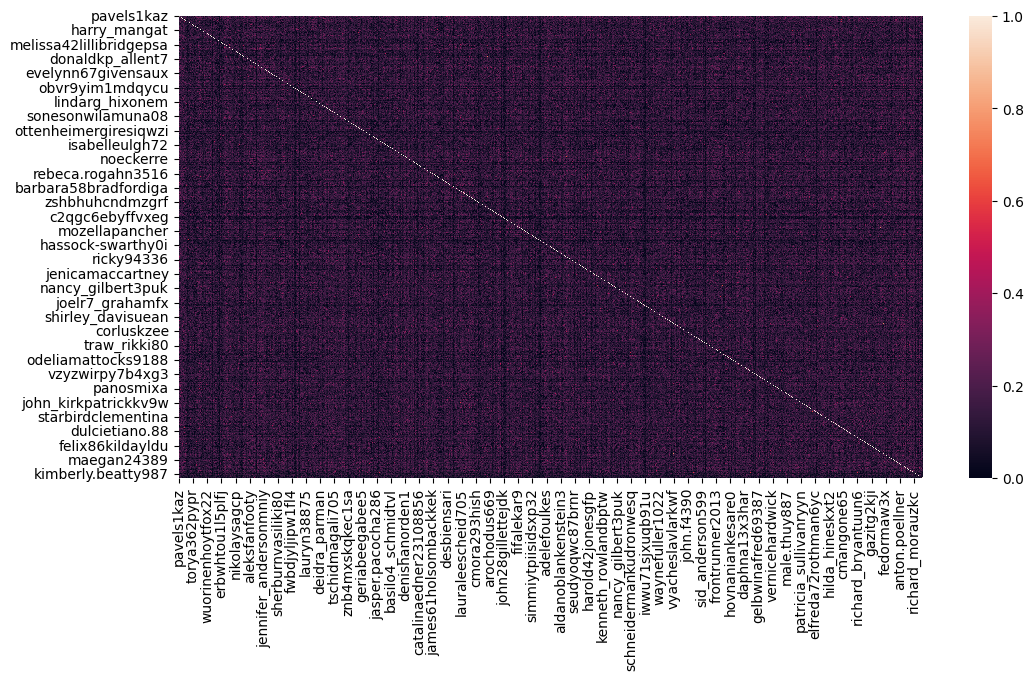

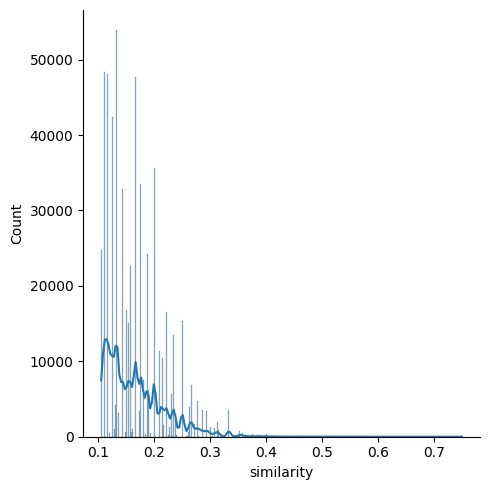

In [117]:
df, df_levenshtein_damerau = email_similarity_score(df)

In [118]:
list(df['email'])

['pavels1kaz@outlook.com',
 'sashanegri@outlook.com',
 'alparke1967@aol.com',
 'felecia_montgomerybnhc@outlook.com',
 'raquelgarriga@hottestinbox.nl',
 'robenaladson81690@outlook.com',
 'versiecervantez@hotmail.com',
 'jaimerzchr@hotmail.com',
 'krystalspinka573@gmx.com',
 'pajonlaborde@outlook.com',
 'sgalliyq@outlook.com',
 'xsn395cxun@hotmail.com',
 'janicetritsch7963@outlook.com',
 'joseph23leth4l0@outlook.com',
 'gaylord57461@web.de',
 'nurahajaru@gmail.com',
 'mezipaphosw@outlook.com',
 'jorge54pale767@outlook.com',
 'blythecirka@outlook.com',
 'torya362pypr@hotmail.com',
 'mark61carrollbbi@outlook.com',
 'begen5112tbnsj@outlook.com',
 'mathew14jerveyi2d@outlook.com',
 'elissa_benefielduyqy@outlook.com',
 'david_johnsonfgon@outlook.com',
 'iliasmpogdanhs@gmail.com',
 'learampton745@outlook.com',
 'jaycieeewb@outlook.com',
 'cantostiesha@outlook.com',
 'wegleitneri7@outlook.com',
 'claemely9494@outlook.com',
 'harry_mangat@outlook.com',
 'kevin96_eggegb@outlook.com',
 'zurmiller76

In [122]:
df

,email,email_username,email_domain,email_tld,email_similarity_score
0,pavels1kaz@outlook.com,pavels1kaz,outlook,com,0.501232
1,sashanegri@outlook.com,sashanegri,outlook,com,0.714154
2,alparke1967@aol.com,alparke1967,aol,com,0.557454
3,felecia_montgomerybnhc@outlook.com,felecia_montgomerybnhc,outlook,com,0.680471
4,raquelgarriga@hottestinbox.nl,raquelgarriga,hottestinbox,nl,0.594320
...,...,...,...,...,...
995,bartkow.patrina1980@hotmail.com,bartkow.patrina1980,hotmail,com,0.707310
996,marusak9908kwgkj@hotmail.com,marusak9908kwgkj,hotmail,com,0.296827
997,limifalbica@gmx.com,limifalbica,gmx,com,0.513364
998,jeannasysoria@hotmail.com,jeannasysoria,hotmail,com,0.608531


In [124]:
ths = .8
df[df['email_similarity_score'] >= ths]

,email,email_username,email_domain,email_tld,email_similarity_score
142,aarneyarneyalena1@outlook.com,aarneyarneyalena1,outlook,com,0.816461
392,nyunaigarzov@outlook.com,nyunaigarzov,outlook,com,1.000000
601,ardeliarierson64@outlook.com,ardeliarierson64,outlook,com,0.805159
814,nyunaigarzov@outlook.com,nyunaigarzov,outlook,com,1.000000


In [132]:
ths = .5
df_ = df_levenshtein_damerau[df_levenshtein_damerau['similarity'] >= ths]
df_

,user_1,user_2,similarity
534,pavels1kaz,pavele19m,0.600000
621,pavels1kaz,yaeltkac,0.500000
7890,jaimerzchr,janicelichvar,0.538462
12890,janicetritsch7963,janicelichvar,0.529412
13483,joseph23leth4l0,joseph72weichel0we,0.555556
...,...,...,...
988270,richard_morauzkc,richard_jonesxesh,0.529412
988692,richard_morauzkc,richardcx_mclucaskc,0.578947
988768,richard_morauzkc,richard_messerpbkd,0.555556
988912,richard_morauzkc,richard_bryantuun6,0.555556


In [133]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_)

                       user_1                 user_2  similarity
534                pavels1kaz              pavele19m    0.600000
621                pavels1kaz               yaeltkac    0.500000
7890               jaimerzchr          janicelichvar    0.538462
12890       janicetritsch7963          janicelichvar    0.529412
13483         joseph23leth4l0     joseph72weichel0we    0.555556
19664            torya362pypr            tonyaa2gjtr    0.500000
23363    elissa_benefielduyqy      melissa_evansldur    0.500000
24640       david_johnsonfgon      david89johnsoncb7    0.647059
28806            cantostiesha              panosmixa    0.500000
29347            wegleitneri7           flegleterica    0.500000
31825            harry_mangat               ryangatt    0.500000
35241             nikitat14ma           nikitaponi4f    0.500000
47229              debralanci         debra74loweavc    0.500000
47243              debralanci              ber.alana    0.500000
61068         sandra_ryan

# Optimized Version

In [138]:
df_username = df[['email_username']]
df_username

,email_username
0,pavels1kaz
1,sashanegri
2,alparke1967
3,felecia_montgomerybnhc
4,raquelgarriga
...,...
995,bartkow.patrina1980
996,marusak9908kwgkj
997,limifalbica
998,jeannasysoria


- medoid_username: the most representative username in a cluster—we choose the node with the highest total edge similarity to others in that cluster (like a centroid but for graphs).
- canonical_label: a stable text label for the cluster: we unify separators (./-/_ → _) and collapse any digit runs to 0.
 

In [228]:
# ---
# Username similarity + clustering (robust ints, isolates = -1, full user mapping)
# - Keeps digits & punctuation
# - Multi-view LSH candidate gen (raw / sep / shape / deleet)
# - Exact refinement with combined similarity
# - Clusters: connected components over edges >= cluster_edge_min_sim
# - Isolates: users with no edges get cluster_id = -1
# - cluster_summary includes one summary row for isolates (cluster_id = -1)
# - Per-user scores: SUM & MEAN over same-cluster neighbors
# - pairs_df includes cluster_id_1 / cluster_id_2 / same_cluster / pair_cluster_id (all ints)
# - Inter-cluster links exclude isolates by default
#
# Dependencies (run once if needed):
# %pip install datasketch rapidfuzz pandas numpy
# ---

import re
import os
from typing import Iterable, Dict, Tuple, Set, Sequence, List, Optional
import numpy as np
import pandas as pd
from datasketch import MinHash, MinHashLSH
from rapidfuzz.distance import DamerauLevenshtein as DL
from rapidfuzz.distance import JaroWinkler as JW
from rapidfuzz import fuzz

# ---------------------------
# Safe casting helpers (avoid IntCastingNaNError)
# ---------------------------

def safe_cast_int(s: pd.Series, default: int = 0) -> pd.Series:
    return (pd.to_numeric(s, errors="coerce")
              .replace([np.inf, -np.inf], np.nan)
              .fillna(default)
              .astype(int))

def safe_cast_float(s: pd.Series, default: float = 0.0) -> pd.Series:
    return (pd.to_numeric(s, errors="coerce")
              .replace([np.inf, -np.inf], np.nan)
              .fillna(default)
              .astype(float))

# ---------------------------
# Normalization & transforms
# ---------------------------

def norm(u: str) -> str:
    """Lowercase + trim; keep digits & punctuation."""
    return "" if u is None else str(u).strip().lower()

def sep_norm(u: str) -> str:
    """Unify separators: non-alnum -> '_' (collapse runs)."""
    u = norm(u)
    u = re.sub(r"[^a-z0-9]", "_", u)
    u = re.sub(r"_+", "_", u).strip("_")
    return u

_LEET = str.maketrans({"0":"o","1":"i","3":"e","4":"a","5":"s","7":"t","8":"b","@":"a","$":"s","!":"i"})
def deleet_norm(u: str) -> str:
    """Map common leetspeak to letters; keep punctuation."""
    return norm(u).translate(_LEET)

def shape(u: str) -> str:
    """letters->a, digits->d, specials->s; collapse runs."""
    u = "" if u is None else str(u)
    out, last = [], None
    for ch in u:
        t = "a" if ch.isalpha() else ("d" if ch.isdigit() else "s")
        if t != last:
            out.append(t); last = t
    return "".join(out)

def letters_only(u: str) -> str:
    return re.sub(r"[^a-zA-Z]+", "", str(u)).lower()

def tokens_for_ratio(u: str) -> str:
    """Separators -> spaces for token_set_ratio; keeps digits as tokens."""
    u = norm(u)
    u = re.sub(r"[^a-z0-9]", " ", u)
    u = re.sub(r"\s+", " ", u).strip()
    return u

def canonical_label(u: str) -> str:
    """Separator-unified & digit-runs collapsed → stable cluster label."""
    s = sep_norm(u)
    s = re.sub(r"\d+", "0", s)
    return s

# ---------------------------
# Shingles & MinHash / LSH
# ---------------------------

def make_shingles(s: str, n_values: Sequence[int] = (2,3,4)) -> Set[str]:
    s = "" if s is None else str(s)
    S = set()
    for n in n_values:
        if len(s) < n:
            if s: S.add(s)
        else:
            for i in range(len(s)-n+1):
                S.add(s[i:i+n])
    return S

def build_minhash(shingles: Set[str], num_perm: int = 128) -> MinHash:
    mh = MinHash(num_perm=num_perm)
    for sh in shingles:
        mh.update(sh.encode("utf-8"))
    return mh

def build_view_index(
    items: Iterable[str], transform, n_values=(2,3,4), num_perm=128, threshold=0.65
) -> Tuple[MinHashLSH, Dict[str, MinHash]]:
    mhs: Dict[str, MinHash] = {}
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    for u in items:
        t = transform(u)
        mh = build_minhash(make_shingles(t, n_values), num_perm=num_perm)
        mhs[u] = mh
        lsh.insert(u, mh)
    return lsh, mhs

def build_multi_view_indices(
    usernames: Iterable[str], num_perm=128, thresholds: Dict[str, float] = None
) -> Dict[str, Tuple[MinHashLSH, Dict[str, MinHash]]]:
    if thresholds is None:
        thresholds = {"raw":0.65,"sep":0.60,"shape":0.85,"deleet":0.65}
    users = [u for u in (norm(x) for x in usernames) if u]
    idx_raw    = build_view_index(users, transform=norm,       n_values=(2,3,4), num_perm=num_perm, threshold=thresholds["raw"])
    idx_sep    = build_view_index(users, transform=sep_norm,   n_values=(2,3,4), num_perm=num_perm, threshold=thresholds["sep"])
    idx_shape  = build_view_index(users, transform=shape,      n_values=(3,),    num_perm=num_perm, threshold=thresholds["shape"])
    idx_deleet = build_view_index(users, transform=deleet_norm,n_values=(2,3,4), num_perm=num_perm, threshold=thresholds["deleet"])
    return {"raw":idx_raw,"sep":idx_sep,"shape":idx_shape,"deleet":idx_deleet}

def multi_view_candidates(indices: Dict[str, Tuple[MinHashLSH, Dict[str, MinHash]]]) -> pd.DataFrame:
    users = list(indices["raw"][1].keys())
    seen, pairs = set(), []
    for u in users:
        cand_union = set()
        for _, (lsh, mhs) in indices.items():
            cand_union.update(lsh.query(mhs[u]))
        for v in cand_union:
            if u >= v: continue
            key = (u,v)
            if key in seen: continue
            seen.add(key)
            jacc = indices["raw"][1][u].jaccard(indices["raw"][1][v])
            pairs.append((u, v, float(jacc)))
    return pd.DataFrame(pairs, columns=["user_1","user_2","jaccard_raw_view"])

# ---------------------------
# Refinement (exact & robust)
# ---------------------------

def combined_similarity(u: str, v: str) -> float:
    u_raw, v_raw = u, v
    u_sep, v_sep = sep_norm(u), sep_norm(v)
    u_del, v_del = deleet_norm(u), deleet_norm(v)
    u_tok, v_tok = tokens_for_ratio(u), tokens_for_ratio(v)

    s1 = DL.normalized_similarity(u_raw, v_raw)
    s2 = DL.normalized_similarity(u_sep, v_sep)
    s3 = DL.normalized_similarity(u_del, v_del)
    s4 = JW.normalized_similarity(u_raw, v_raw)
    s5 = fuzz.token_set_ratio(u_tok, v_tok) / 100.0

    u_let, v_let = letters_only(u_raw), letters_only(v_raw)
    boost = 0.05 if (u_let and v_let and DL.normalized_similarity(u_let, v_let) >= 0.90) else 0.0
    return min(1.0, max(s1, s2, s3, s4, s5) + boost)

def refine_pairs(pairs_df: pd.DataFrame, min_sim: float = 0.70) -> pd.DataFrame:
    if pairs_df.empty:
        out = pairs_df.copy(); out["similarity"] = []
        return out
    sims = [combined_similarity(u, v) for u, v in pairs_df[["user_1","user_2"]].itertuples(index=False)]
    out = pairs_df.copy()
    out["similarity"] = sims
    return out[out["similarity"] >= min_sim].reset_index(drop=True)

# ---------------------------
# Clusters (+ isolates = -1) with labels & centroid metrics
# ---------------------------

def extract_clusters_with_labels(
    pairs_df: pd.DataFrame,
    min_sim: float = 0.70,
    include_singletons: bool = True,
    all_usernames: Optional[List[str]] = None,
    include_isolates_summary: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build clusters from edges >= min_sim. Users with no edges get cluster_id = -1.
    cluster_summary includes multi-user clusters (id 1..K) + one isolates row (id = -1).
    """
    pf = pairs_df[pairs_df["similarity"] >= min_sim].copy()

    def _build_adj_local(pdf: pd.DataFrame) -> Dict[str, Set[str]]:
        adj: Dict[str, Set[str]] = {}
        for u, v in pdf[["user_1","user_2"]].itertuples(index=False):
            adj.setdefault(u, set()).add(v)
            adj.setdefault(v, set()).add(u)
        return adj

    def _connected_components(adj: Dict[str, Set[str]]) -> List[List[str]]:
        seen, comps = set(), []
        for start in adj.keys():
            if start in seen: continue
            stack = [start]; seen.add(start); comp=[]
            while stack:
                x = stack.pop(); comp.append(x)
                for y in adj.get(x, ()):
                    if y not in seen:
                        seen.add(y); stack.append(y)
            comps.append(comp)
        return comps

    adj = _build_adj_local(pf)
    comps = _connected_components(adj)
    multi_comps = [c for c in comps if len(c) > 1]

    # singletons (no qualified edges)
    singleton_usernames: List[str] = []
    if include_singletons:
        nodes_seen = set(all_usernames) if all_usernames is not None else set(pairs_df["user_1"]).union(set(pairs_df["user_2"]))
        singleton_usernames = [u for u in nodes_seen if u not in adj]

    user_rows, cluster_rows = [], []
    cid = 1  # positive ids for multi-user clusters

    # multi-user clusters
    for nodes in multi_comps:
        sub = pf[(pf["user_1"].isin(nodes)) & (pf["user_2"].isin(nodes))]

        # node weights (incident similarity)
        weights = {u:0.0 for u in nodes}
        if not sub.empty:
            for u, s in sub.groupby("user_1")["similarity"].sum().items(): weights[u] += float(s)
            for v, s in sub.groupby("user_2")["similarity"].sum().items(): weights[v] += float(s)

        medoid = max(weights.items(), key=lambda kv: kv[1])[0] if nodes else None

        if medoid is not None and not sub.empty:
            med_edges = pd.concat([
                sub[sub["user_1"] == medoid][["user_2","similarity"]].rename(columns={"user_2":"neighbor"}),
                sub[sub["user_2"] == medoid][["user_1","similarity"]].rename(columns={"user_1":"neighbor"})
            ], ignore_index=True)
            centroid_sum   = float(med_edges["similarity"].sum()) if not med_edges.empty else 0.0
            centroid_mean  = float(med_edges["similarity"].mean()) if not med_edges.empty else 0.0
            centroid_neigh = int(med_edges["neighbor"].nunique()) if not med_edges.empty else 0
            avg_sim = float(sub["similarity"].mean())
        else:
            centroid_sum = centroid_mean = 0.0
            centroid_neigh = 0
            avg_sim = 0.0

        label = canonical_label(medoid) if medoid else ""

        cluster_rows.append({
            "cluster_id": cid,
            "size": len(nodes),
            "medoid_username": medoid,
            "canonical_label": label,
            "avg_similarity": avg_sim,
            "centroid_sum_similarity": centroid_sum,
            "centroid_mean_similarity": centroid_mean,
            "centroid_neighbor_count": centroid_neigh
        })
        for u in nodes:
            user_rows.append({"email_username": u, "cluster_id": cid})
        cid += 1

    # isolates => cluster_id = -1
    for u in singleton_usernames:
        user_rows.append({"email_username": u, "cluster_id": -1})

    user_clusters = pd.DataFrame(user_rows)

    cluster_summary = pd.DataFrame(cluster_rows)
    if include_isolates_summary:
        iso_count = len(singleton_usernames)
        if iso_count > 0:
            iso_row = {
                "cluster_id": -1,
                "size": int(iso_count),
                "medoid_username": None,
                "canonical_label": "__isolates__",
                "avg_similarity": 0.0,
                "centroid_sum_similarity": 0.0,
                "centroid_mean_similarity": 0.0,
                "centroid_neighbor_count": 0
            }
            cluster_summary = pd.concat([cluster_summary, pd.DataFrame([iso_row])], ignore_index=True)

    if not cluster_summary.empty:
        cluster_summary["__is_iso__"] = (cluster_summary["cluster_id"] == -1).astype(int)
        cluster_summary = (cluster_summary
                            .sort_values(["__is_iso__","size","avg_similarity"], ascending=[True, False, False])
                            .drop(columns="__is_iso__")
                            .reset_index(drop=True))

    # ensure dtypes: ints & floats (no NaN in int columns)
    if not user_clusters.empty:
        user_clusters["cluster_id"] = safe_cast_int(user_clusters["cluster_id"], default=-1)
    for col in ["cluster_id","size","centroid_neighbor_count"]:
        if col in cluster_summary.columns:
            cluster_summary[col] = safe_cast_int(cluster_summary[col], default=0)
    for col in ["avg_similarity","centroid_sum_similarity","centroid_mean_similarity"]:
        if col in cluster_summary.columns:
            cluster_summary[col] = safe_cast_float(cluster_summary[col], default=0.0)

    return user_clusters, cluster_summary

# ---------------------------
# Inter-cluster links (exclude isolates by default)
# ---------------------------

def _cluster_member_map(user_clusters: pd.DataFrame) -> Dict[int, Set[str]]:
    m: Dict[int, Set[str]] = {}
    for cid, grp in user_clusters.groupby("cluster_id"):
        m[int(cid)] = set(grp["email_username"].astype(str))
    return m

def build_cluster_signatures(user_clusters: pd.DataFrame, n_values=(2,3,4)) -> Dict[int, Set[str]]:
    sigs: Dict[int, Set[str]] = {}
    member_map = _cluster_member_map(user_clusters)
    for cid, members in member_map.items():
        if cid == -1:  # skip isolates bucket
            continue
        S: Set[str] = set()
        for u in members:
            S.update(make_shingles(sep_norm(u), n_values))
            S.update(make_shingles(deleet_norm(u), n_values))
        sigs[int(cid)] = S
    return sigs

def cluster_links_via_signatures(
    cluster_summary: pd.DataFrame,
    user_clusters: pd.DataFrame,
    num_perm: int = 128,
    lsh_threshold: float = 0.55,
    min_sim: float = 0.65,
    include_isolates: bool = False
) -> pd.DataFrame:
    # Exclude isolates by default
    if not include_isolates:
        cluster_summary = cluster_summary[cluster_summary["cluster_id"] != -1].copy()
        user_clusters   = user_clusters[user_clusters["cluster_id"] != -1].copy()

    if cluster_summary.empty or cluster_summary["cluster_id"].nunique() <= 1:
        return pd.DataFrame(columns=["cluster_id_1","cluster_id_2","cluster_similarity"])

    sigs = build_cluster_signatures(user_clusters, n_values=(2,3,4))
    if not sigs:
        return pd.DataFrame(columns=["cluster_id_1","cluster_id_2","cluster_similarity"])

    mh: Dict[int, MinHash] = {}
    lsh = MinHashLSH(threshold=lsh_threshold, num_perm=num_perm)
    for cid, S in sigs.items():
        mh_c = build_minhash(S, num_perm=num_perm)
        mh[cid] = mh_c
        lsh.insert(str(cid), mh_c)

    labels = cluster_summary.set_index("cluster_id")["canonical_label"].astype(str).to_dict()

    links = []
    for cid in sigs.keys():
        cands = lsh.query(mh[cid])
        for other_str in cands:
            other = int(other_str)
            if cid >= other: continue
            jacc_est  = mh[cid].jaccard(mh[other])
            label_sim = combined_similarity(labels.get(cid, ""), labels.get(other, ""))
            sim = max(float(jacc_est), float(label_sim))
            if sim >= min_sim:
                links.append((int(cid), int(other), float(sim)))

    links_df = pd.DataFrame(links, columns=["cluster_id_1","cluster_id_2","cluster_similarity"])
    if not links_df.empty:
        links_df["cluster_id_1"] = safe_cast_int(links_df["cluster_id_1"], 0)
        links_df["cluster_id_2"] = safe_cast_int(links_df["cluster_id_2"], 0)
        links_df["cluster_similarity"] = safe_cast_float(links_df["cluster_similarity"], 0.0)
    return links_df

# ---------------------------
# Per-user features (SUM & MEAN over same-cluster neighbors)
# ---------------------------

def user_features_sum_mean_same_cluster(
    refined_pairs_with_clusters: pd.DataFrame,
    cluster_edge_min_sim: float,
    neighbor_threshold: int
) -> pd.DataFrame:
    """
    Uses only same-cluster edges with similarity >= cluster_edge_min_sim.
    Computes:
      - username_similarity_score (SUM)
      - username_similarity_mean_score (MEAN)
      - similarity_neighbors_count
      - too_many_similar_usernames_flag
    """
    cols = [
        "email_username","username_similarity_score","username_similarity_mean_score",
        "similarity_neighbors_count","too_many_similar_usernames_flag"
    ]
    if refined_pairs_with_clusters.empty:
        return pd.DataFrame(columns=cols)

    sc = refined_pairs_with_clusters[
        (refined_pairs_with_clusters["same_cluster"] == 1) &
        (refined_pairs_with_clusters["similarity"] >= cluster_edge_min_sim)
    ]
    if sc.empty:
        return pd.DataFrame(columns=cols)

    a = sc[["user_1","similarity"]].rename(columns={"user_1":"email_username"})
    b = sc[["user_2","similarity"]].rename(columns={"user_2":"email_username"})
    stacked = pd.concat([a,b], ignore_index=True)

    agg = stacked.groupby("email_username")["similarity"].agg(sum="sum", mean="mean", count="count").reset_index()
    agg.rename(columns={
        "sum":"username_similarity_score",
        "mean":"username_similarity_mean_score",
        "count":"similarity_neighbors_count"
    }, inplace=True)
    agg["too_many_similar_usernames_flag"] = (agg["similarity_neighbors_count"] > neighbor_threshold).astype(int)

    # ensure numeric types (no NaN ints)
    for col in ["username_similarity_score","username_similarity_mean_score"]:
        agg[col] = safe_cast_float(agg[col], 0.0)
    for col in ["similarity_neighbors_count","too_many_similar_usernames_flag"]:
        agg[col] = safe_cast_int(agg[col], 0)
    return agg

# ---------------------------
# Orchestrator
# ---------------------------

def username_similarity_score_optimized(
    df: pd.DataFrame,
    visualize: bool = False,
    num_perm: int = 128,
    thresholds: Dict[str, float] = None,
    min_refined_similarity: float = 0.70,
    neighbor_threshold: int = 2,
    cluster_edge_min_sim: float = 0.70,
    cluster_lsh_threshold: float = 0.55,
    cluster_link_min_sim: float = 0.65,
    audit_top_k: int = 20,
    output_dir: str = ".",
):
    """
    Returns:
      out_df          : original df + cluster_id + per-user SUM & MEAN scores + counts/flag
      refined_pairs   : user-user pairs with similarity + cluster_id_1/2 + same_cluster + pair_cluster_id
      user_clusters   : full mapping of ALL usernames → cluster_id (isolates = -1)
      cluster_summary : multi-user clusters + one summary row for isolates (cluster_id = -1)
      cluster_links   : inter-cluster links (isolates excluded by default)
    """
    if "email_username" not in df.columns:
        raise ValueError("df must contain 'email_username'")

    # All unique normalized usernames (source for full coverage)
    usernames = (df["email_username"].map(norm).replace("", np.nan).dropna().unique().tolist())

    # Candidate generation via multi-view LSH
    indices    = build_multi_view_indices(usernames, num_perm=num_perm, thresholds=thresholds)
    candidates = multi_view_candidates(indices)

    # Exact refinement
    refined_pairs = refine_pairs(candidates, min_sim=min_refined_similarity)

    # Clusters (+ isolates = -1) & summary (with isolates row)
    user_clusters_unique, cluster_summary = extract_clusters_with_labels(
        refined_pairs,
        min_sim=cluster_edge_min_sim,
        include_singletons=True,
        all_usernames=usernames,
        include_isolates_summary=True
    )

    # Add cluster IDs to pairs_df
    if not refined_pairs.empty and not user_clusters_unique.empty:
        _u2c = user_clusters_unique.set_index("email_username")["cluster_id"]
        refined_pairs = refined_pairs.copy()
        refined_pairs["cluster_id_1"] = refined_pairs["user_1"].map(_u2c)
        refined_pairs["cluster_id_2"] = refined_pairs["user_2"].map(_u2c)
        refined_pairs["same_cluster"]  = (refined_pairs["cluster_id_1"] == refined_pairs["cluster_id_2"]).astype(int)
        refined_pairs["pair_cluster_id"] = np.where(refined_pairs["same_cluster"] == 1,
                                                    refined_pairs["cluster_id_1"], -1)
        # safe cast ints
        refined_pairs["cluster_id_1"] = safe_cast_int(refined_pairs["cluster_id_1"], default=-1)
        refined_pairs["cluster_id_2"] = safe_cast_int(refined_pairs["cluster_id_2"], default=-1)
        refined_pairs["same_cluster"] = safe_cast_int(refined_pairs["same_cluster"], 0)
        refined_pairs["pair_cluster_id"] = safe_cast_int(refined_pairs["pair_cluster_id"], -1)

        # reorder columns
        base_cols = ["user_1","user_2","cluster_id_1","cluster_id_2","same_cluster","pair_cluster_id"]
        other_cols = [c for c in refined_pairs.columns if c not in base_cols]
        refined_pairs = refined_pairs[base_cols + other_cols]

    # Per-user SUM & MEAN features (same-cluster neighbors only)
    user_feats = user_features_sum_mean_same_cluster(refined_pairs, cluster_edge_min_sim, neighbor_threshold)

    # Build FULL user_clusters mapping (coverage = ALL usernames)
    all_users_df = pd.DataFrame({"email_username": usernames})
    user_clusters_full = all_users_df.merge(user_clusters_unique, how="left", on="email_username")
    user_clusters_full["cluster_id"] = safe_cast_int(user_clusters_full["cluster_id"], default=-1)

    # out_df with cluster_id + user scores (merge on normalized)
    out_df = df.copy()
    out_df["_uname_norm"] = out_df["email_username"].map(norm)

    out_df = out_df.merge(
        user_clusters_full.rename(columns={"email_username":"_uname_norm"}),
        how="left", on="_uname_norm"
    )
    out_df = out_df.merge(
        user_feats.rename(columns={"email_username":"_uname_norm"}),
        how="left", on="_uname_norm"
    )
    out_df.drop(columns=["_uname_norm"], inplace=True, errors="ignore")

    # Fill defaults & cast
    if "cluster_id" in out_df.columns:
        out_df["cluster_id"] = safe_cast_int(out_df["cluster_id"], default=-1)
    for col in ["username_similarity_score","username_similarity_mean_score"]:
        if col in out_df.columns:
            out_df[col] = safe_cast_float(out_df[col], 0.0)
    for col in ["similarity_neighbors_count","too_many_similar_usernames_flag"]:
        if col in out_df.columns:
            out_df[col] = safe_cast_int(out_df[col], 0)

    # Inter-cluster links (exclude isolates by default)
    cluster_links = cluster_links_via_signatures(
        cluster_summary=cluster_summary,
        user_clusters=user_clusters_full,
        num_perm=num_perm,
        lsh_threshold=cluster_lsh_threshold,
        min_sim=cluster_link_min_sim,
        include_isolates=False
    )

    # Optional audit
    if visualize and not refined_pairs.empty:
        os.makedirs(output_dir, exist_ok=True)
        refined_pairs.sort_values("similarity", ascending=False).head(audit_top_k) \
            .to_csv(os.path.join(output_dir, "username_similarity_top_pairs.csv"), index=False)

    return out_df, refined_pairs, user_clusters_full, cluster_summary, cluster_links

In [239]:
# Add these imports once (near your other imports)
import logging
import time
 
# Optional one-liner to see INFO logs in a notebook:
# logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")
 
def username_similarity_score_optimized(
    df: pd.DataFrame,
    visualize: bool = False,
    num_perm: int = 128,
    thresholds: Dict[str, float] = None,
    min_refined_similarity: float = 0.70,
    neighbor_threshold: int = 2,
    cluster_edge_min_sim: float = 0.70,
    cluster_lsh_threshold: float = 0.55,
    cluster_link_min_sim: float = 0.65,
    audit_top_k: int = 20,
    output_dir: str = ".",
):
    """
    Returns:
      out_df          : original df + cluster_id + per-user SUM & MEAN scores + counts/flag
      refined_pairs   : user-user pairs with similarity + cluster_id_1/2 + same_cluster + pair_cluster_id
      user_clusters   : full mapping of ALL usernames → cluster_id (isolates = -1)
      cluster_summary : multi-user clusters + one summary row for isolates (cluster_id = -1)
      cluster_links   : inter-cluster links (isolates excluded by default)
    """
    t_start = time.perf_counter()
    logging.info("username_similarity_score_optimized: start")
 
    if "email_username" not in df.columns:
        logging.error("Input DataFrame is missing 'email_username' column.")
        raise ValueError("df must contain 'email_username'")
 
    logging.info(
        "Params | num_perm=%d | min_refined_similarity=%.3f | cluster_edge_min_sim=%.3f | "
        "cluster_lsh_threshold=%.3f | cluster_link_min_sim=%.3f | neighbor_threshold=%d",
        num_perm, min_refined_similarity, cluster_edge_min_sim,
        cluster_lsh_threshold, cluster_link_min_sim, neighbor_threshold
    )
    if thresholds is not None:
        logging.info("Per-view LSH thresholds: %s", thresholds)
 
    # All unique normalized usernames (source for full coverage)
    usernames = (df["email_username"].map(norm).replace("", np.nan).dropna().unique().tolist())
    n_users = len(usernames)
    logging.info("Unique normalized usernames: %,d", n_users)
 
    # Candidate generation via multi-view LSH
    t0 = time.perf_counter()
    indices = build_multi_view_indices(usernames, num_perm=num_perm, thresholds=thresholds)
    t1 = time.perf_counter()
    logging.info(
        "Built multi-view LSH indices in %.2fs (raw=%d, sep=%d, shape=%d, deleet=%d)",
        (t1 - t0),
        len(indices["raw"][1]), len(indices["sep"][1]), len(indices["shape"][1]), len(indices["deleet"][1])
    )
 
    # Union of candidates across views
    t2 = time.perf_counter()
    candidates = multi_view_candidates(indices)
    t3 = time.perf_counter()
    n_cand = len(candidates)
    avg_cand_per_user = (2 * n_cand / n_users) if n_users else 0.0
    logging.info("Candidate pairs via LSH: %,d (avg ~ %.2f per user) in %.2fs", n_cand, avg_cand_per_user, (t3 - t2))
 
    # Exact refinement
    t4 = time.perf_counter()
    refined_pairs = refine_pairs(candidates, min_sim=min_refined_similarity)
    t5 = time.perf_counter()
    logging.info(
        "Refined pairs kept >= %.2f: %,d (from %,d), refine time %.2fs",
        min_refined_similarity, len(refined_pairs), n_cand, (t5 - t4)
    )
 
    # Clusters (+ isolates = -1) & summary (with isolates row)
    t6 = time.perf_counter()
    user_clusters_unique, cluster_summary = extract_clusters_with_labels(
        refined_pairs,
        min_sim=cluster_edge_min_sim,
        include_singletons=True,
        all_usernames=usernames,
        include_isolates_summary=True
    )
    t7 = time.perf_counter()
 
    # Summaries
    n_multi_clusters = int(cluster_summary.loc[cluster_summary["cluster_id"] != -1, "cluster_id"].nunique()) if not cluster_summary.empty else 0
    isolates_in_summary = int(cluster_summary.loc[cluster_summary["cluster_id"] == -1, "size"].sum()) if not cluster_summary.empty else 0
    logging.info(
        "Cluster extraction in %.2fs | multi-user clusters: %d | isolates summary size: %d",
        (t7 - t6), n_multi_clusters, isolates_in_summary
    )
 
    # Add cluster IDs to pairs_df
    if not refined_pairs.empty and not user_clusters_unique.empty:
        _u2c = user_clusters_unique.set_index("email_username")["cluster_id"]
        refined_pairs = refined_pairs.copy()
        refined_pairs["cluster_id_1"] = refined_pairs["user_1"].map(_u2c)
        refined_pairs["cluster_id_2"] = refined_pairs["user_2"].map(_u2c)
        refined_pairs["same_cluster"]  = (refined_pairs["cluster_id_1"] == refined_pairs["cluster_id_2"]).astype(int)
        refined_pairs["pair_cluster_id"] = np.where(refined_pairs["same_cluster"] == 1,
                                                    refined_pairs["cluster_id_1"], -1)
        # safe cast ints
        refined_pairs["cluster_id_1"] = safe_cast_int(refined_pairs["cluster_id_1"], default=-1)
        refined_pairs["cluster_id_2"] = safe_cast_int(refined_pairs["cluster_id_2"], default=-1)
        refined_pairs["same_cluster"] = safe_cast_int(refined_pairs["same_cluster"], 0)
        refined_pairs["pair_cluster_id"] = safe_cast_int(refined_pairs["pair_cluster_id"], -1)
 
        # reorder columns
        base_cols = ["user_1","user_2","cluster_id_1","cluster_id_2","same_cluster","pair_cluster_id"]
        other_cols = [c for c in refined_pairs.columns if c not in base_cols]
        refined_pairs = refined_pairs[base_cols + other_cols]
 
        n_same_cluster = int((refined_pairs["same_cluster"] == 1).sum())
        logging.info(
            "Pairs annotated with cluster IDs: %,d | same-cluster edges: %,d",
            len(refined_pairs), n_same_cluster
        )
    else:
        logging.info("Skipping pair cluster annotation (refined_pairs or user_clusters_unique is empty).")
 
    # Per-user SUM & MEAN features (same-cluster neighbors only)
    t8 = time.perf_counter()
    user_feats = user_features_sum_mean_same_cluster(refined_pairs, cluster_edge_min_sim, neighbor_threshold)
    t9 = time.perf_counter()
    logging.info(
        "Computed per-user features (sum/mean) for %,d users in %.2fs",
        len(user_feats), (t9 - t8)
    )
 
    # Build FULL user_clusters mapping (coverage = ALL usernames)
    all_users_df = pd.DataFrame({"email_username": usernames})
    user_clusters_full = all_users_df.merge(user_clusters_unique, how="left", on="email_username")
    user_clusters_full["cluster_id"] = safe_cast_int(user_clusters_full["cluster_id"], default=-1)
 
    isolates_count = int((user_clusters_full["cluster_id"] == -1).sum())
    logging.info(
        "Built full user→cluster mapping: %,d rows | isolates: %,d",
        len(user_clusters_full), isolates_count
    )
 
    # out_df with cluster_id + user scores (merge on normalized)
    out_df = df.copy()
    out_df["_uname_norm"] = out_df["email_username"].map(norm)
 
    out_df = out_df.merge(
        user_clusters_full.rename(columns={"email_username":"_uname_norm"}),
        how="left", on="_uname_norm"
    )
    out_df = out_df.merge(
        user_feats.rename(columns={"email_username":"_uname_norm"}),
        how="left", on="_uname_norm"
    )
    out_df.drop(columns=["_uname_norm"], inplace=True, errors="ignore")
 
    # Fill defaults & cast
    if "cluster_id" in out_df.columns:
        out_df["cluster_id"] = safe_cast_int(out_df["cluster_id"], default=-1)
    for col in ["username_similarity_score","username_similarity_mean_score"]:
        if col in out_df.columns:
            out_df[col] = safe_cast_float(out_df[col], 0.0)
    for col in ["similarity_neighbors_count","too_many_similar_usernames_flag"]:
        if col in out_df.columns:
            out_df[col] = safe_cast_int(out_df[col], 0)
 
    logging.info(
        "out_df ready: %,d rows x %,d cols | users flagged: %,d",
        len(out_df), out_df.shape[1],
        int(out_df.get("too_many_similar_usernames_flag", pd.Series([], dtype=int)).sum())
    )
 
    # Inter-cluster links (exclude isolates by default)
    t10 = time.perf_counter()
    cluster_links = cluster_links_via_signatures(
        cluster_summary=cluster_summary,
        user_clusters=user_clusters_full,
        num_perm=num_perm,
        lsh_threshold=cluster_lsh_threshold,
        min_sim=cluster_link_min_sim,
        include_isolates=False
    )
    t11 = time.perf_counter()
    logging.info(
        "Inter-cluster links: %,d in %.2fs (isolates excluded)",
        len(cluster_links), (t11 - t10)
    )
 
    # Optional audit
    if visualize and not refined_pairs.empty:
        try:
            os.makedirs(output_dir, exist_ok=True)
            path = os.path.join(output_dir, "username_similarity_top_pairs.csv")
            refined_pairs.sort_values("similarity", ascending=False).head(audit_top_k).to_csv(path, index=False)
            logging.info("Saved top %d pairs to %s", audit_top_k, path)
        except Exception as e:
            logging.warning("Failed to save audit CSV: %s", e)
 
    logging.info(
        "username_similarity_score_optimized: done in %.2fs",
        (time.perf_counter() - t_start)
    )
 
    return out_df, refined_pairs, user_clusters_full, cluster_summary, cluster_links

In [240]:
out_df, pairs_df, user_clusters, cluster_summary, cluster_links = username_similarity_score_optimized(
    df_username,
    visualize=False,           # set True to save a CSV of top pairs
    num_perm=128,              # MinHash size (higher = better recall, slower)
    thresholds={"raw": 0.65, "sep": 0.60, "shape": 0.85, "deleet": 0.65},
    min_refined_similarity=0.70,   # keep user-user pairs with sim >= 0.70
    neighbor_threshold=2,          # flag if a user has > 2 same-cluster neighbors
    cluster_edge_min_sim=0.70,     # edges used to form clusters
    cluster_lsh_threshold=0.55,    # LSH for cluster links (signature-based)
    cluster_link_min_sim=0.65,     # keep cluster links with sim >= 0.65
    audit_top_k=50,
    output_dir="."
)
 
# Inspect key outputs
print("=== Users with scores & cluster_id ===")
display(out_df.sort_values(["too_many_similar_usernames_flag","similarity_neighbors_count","username_similarity_score"],
                           ascending=[False, False, False]).head(20))
 
print("=== Refined pairs (with cluster IDs) ===")
display(pairs_df.sort_values("similarity", ascending=False))
 
print("=== User → Cluster ===")
display(user_clusters.sort_values(["cluster_id","email_username"]))
 
print("=== Cluster summary (includes centroid SUM & MEAN) ===")
display(cluster_summary.sort_values(["size","centroid_sum_similarity"], ascending=[False, False]).head(20))
 
print("=== Cluster links (inter-cluster similarity) ===")
display(cluster_links.sort_values("cluster_similarity", ascending=False).head(20))

=== Users with scores & cluster_id ===


,email_username,cluster_id,username_similarity_score,username_similarity_mean_score,similarity_neighbors_count,too_many_similar_usernames_flag
460,sharenl1987,12,4.418111,0.736352,6,1
948,georgianaroachell,3,4.413789,0.735632,6,1
752,charlettesho1984,12,3.769230,0.753846,5,1
429,keraranalli,3,3.763537,0.752707,5,1
699,eric,3,3.723990,0.744798,5,1
47,debralanci,3,3.613074,0.722615,5,1
304,denishanorden1,21,3.100186,0.775047,4,1
63,rendacomi,3,2.875746,0.718936,4,1
768,richard_messerpbkd,25,2.555577,0.851859,3,1
521,denisanrey,3,2.388939,0.796313,3,1


=== Refined pairs (with cluster IDs) ===


,user_1,user_2,cluster_id_1,cluster_id_2,same_cluster,pair_cluster_id,jaccard_raw_view,similarity
65,ilyaahng,ilyaahv,13,13,1,13,0.515625,0.921429
127,greogorian-bailey,greogorian-wiegand,53,53,1,53,0.398438,0.905976
26,andriaemmick,andricikw,3,3,1,3,0.250000,0.886111
114,sergey6jsh,sergeys17e,44,44,1,44,0.351562,0.880000
147,richard_morauzkc,richardcx_mclucaskc,25,25,1,25,0.242188,0.868573
...,...,...,...,...,...,...,...,...
62,isidraschwin1975,sharenl1987,12,12,1,12,0.007812,0.700758
117,charlettesho1984,sharenl1987,12,12,1,12,0.093750,0.700758
10,debralanci,rendacomi,3,3,1,3,0.000000,0.700000
19,fhaitawayc,jacintaayash,10,10,1,10,0.031250,0.700000


=== User → Cluster ===


,email_username,cluster_id
848,0.loris_lumper,-1
54,8ymk29p7qm,-1
288,a.arroyo_2009,-1
142,aarneyarneyalena1,-1
759,abdal.paige,-1
...,...,...
31,harry_mangat,57
964,nikmaslovpic,58
76,nikolaysagcp,58
968,anton.poellner,59


=== Cluster summary (includes centroid SUM & MEAN) ===


,cluster_id,size,medoid_username,canonical_label,avg_similarity,centroid_sum_similarity,centroid_mean_similarity,centroid_neighbor_count
59,-1,799,None,__isolates__,0.000000,0.000000,0.000000,0
0,3,40,georgianaroachell,georgianaroachell,0.747705,4.413789,0.735632,6
1,12,17,sharenl1987,sharenl0,0.749205,4.418111,0.736352,6
2,21,9,denishanorden1,denishanorden0,0.755582,3.100186,0.775047,4
3,35,5,mozellduker,mozellduker,0.778030,2.284343,0.761448,3
4,25,4,richard_messerpbkd,richard_messerpbkd,0.856037,2.555577,0.851859,3
5,23,4,roser.amelia,roser_amelia,0.753775,2.261325,0.753775,3
6,31,4,kellogshauna3,kellogshauna0,0.722222,1.459402,0.729701,2
7,48,4,jeannasysoria,jeannasysoria,0.707028,1.411681,0.705840,2
8,44,3,sergeys17e,sergeys0e,0.871515,1.747273,0.873636,2


=== Cluster links (inter-cluster similarity) ===


,cluster_id_1,cluster_id_2,cluster_similarity


In [241]:
# ---------------------------
# Notes:
# - medoid_username: the most "central" username in a cluster — the node whose
#   total similarity to other members (within-cluster edges) is highest. Think
#   of it like a centroid for a graph.
# - canonical_label: a stable, human-readable label for the cluster created by
#   unifying separators and collapsing digit runs (e.g., "john.1990" -> "john_0").
#   It helps reporting and also refines cluster-to-cluster comparisons.
# ---------------------------

In [238]:
user_clusters['cluster_id'].unique()

array([41,  1, -1,  2,  3,  4,  5,  6,  7, 57, 11, 22, 35,  8, 26, 58,  9,
       10, 12, 46, 48, 13, 14, 15, 43, 16, 19, 29, 17, 18, 20, 21, 54, 23,
       31, 33, 24, 25, 36, 27, 40, 28, 30, 52, 32, 39, 34, 55, 51, 37, 38,
       56, 50, 44, 42, 59, 45, 47, 49, 53])

In [235]:
user_clusters.nunique()

email_username    999
cluster_id         60
dtype: int64